In [ ]:
# runtime type GPU
!nvidia-smi

Sat Dec  9 17:15:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from imageio import imread

import torch
import torch.nn
from torchvision.models.vgg import vgg19

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

idx = 10001

gray = imread('/content/drive/MyDrive/Sensor_Fusion_Model/IV_images/VIS%d.jpg' % idx)
ir = imread('/content/drive/MyDrive/Sensor_Fusion_Model/IV_images/IR%d.jpg' % idx)

<ipython-input-9-f3eaecb16b46>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gray = imread('/content/drive/MyDrive/Sensor_Fusion_Model/IV_images/VIS%d.jpg' % idx)
<ipython-input-9-f3eaecb16b46>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ir = imread('/content/drive/MyDrive/Sensor_Fusion_Model/IV_images/IR%d.jpg' % idx)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.7 MB/s eta 0:00:00


/content/drive/MyDrive/Sensor_Fusion_Model/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/content/drive/MyDrive/Sensor_Fusion_Model/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You 

Text(0.5, 1.0, 'Fusion')

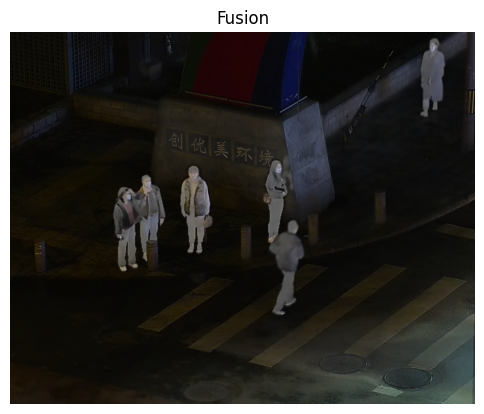

In [ ]:
!pip install sporco
import sys
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/')
from Sensor_Fusion_Model.vggfusion import fuse

# Assuming gray and ir are defined somewhere before this point
plt.figure(figsize=(6, 6))
plt.imshow(fuse(gray, ir), 'gray')
plt.axis('off')
plt.title('Fusion')



/content/drive/MyDrive/Sensor_Fusion_Model/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/content/drive/MyDrive/Sensor_Fusion_Model/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You 

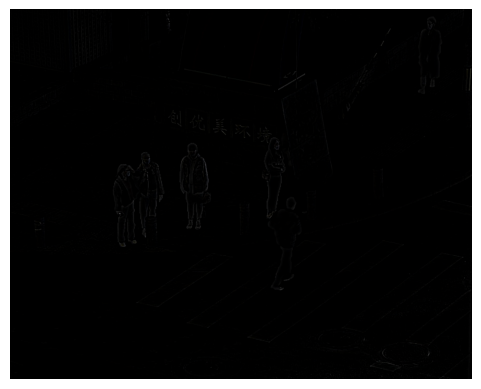

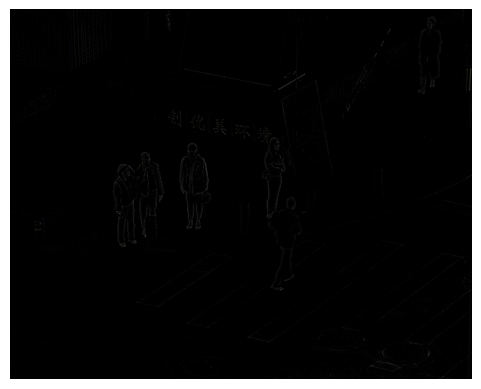

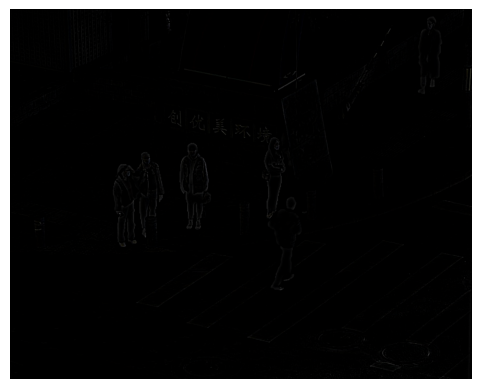

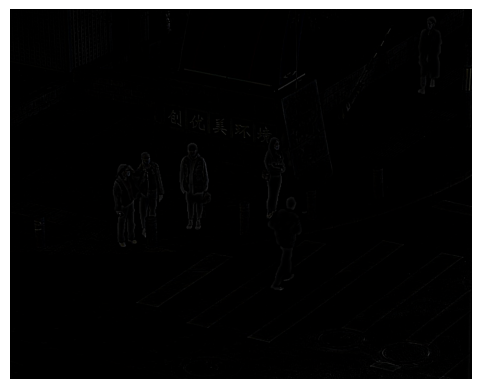

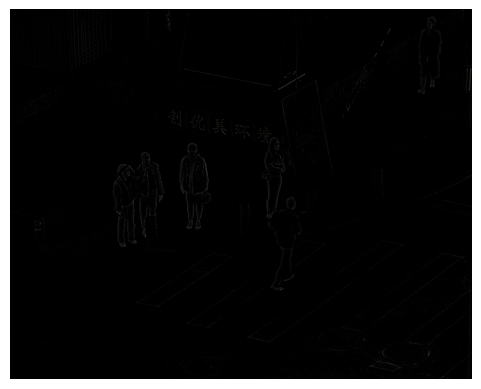

In [ ]:

from Sensor_Fusion_Model.vggfusion import *

npad = 16
lda = 5
graylow, grayhigh = lowpass(gray.astype(np.float32)/255, lda, npad)
irlow, irhigh = lowpass(ir.astype(np.float32)/255, lda, npad)

grayhigh3 = c3(grayhigh)
irhigh3 = c3(irhigh)

model = vgg19(True).cuda().eval()

gray_in = torch.from_numpy(grayhigh3).cuda()
ir_in = torch.from_numpy(irhigh3).cuda()
relus = [2, 7, 12, 21]
unit_relus = [1, 2, 4, 8]

relus_gray = get_activation(model, relus, gray_in)
relus_ir = get_activation(model, relus, ir_in)

gray_feats = [l1_features(out) for out in relus_gray]
ir_feats = [l1_features(out) for out in relus_ir]

saliencies = []
saliency_max = None
for idx in range(len(relus)):
    saliency_current = fusion_strategy(gray_feats[idx], ir_feats[idx], grayhigh, irhigh, unit_relus[idx])
    saliencies.append(saliency_current)

    if saliency_max is None:
        saliency_max = saliency_current
    else:
        saliency_max = np.maximum(saliency_max, saliency_current)

    plt.imshow(saliency_current, 'gray')
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max, 'gray')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Fusion')

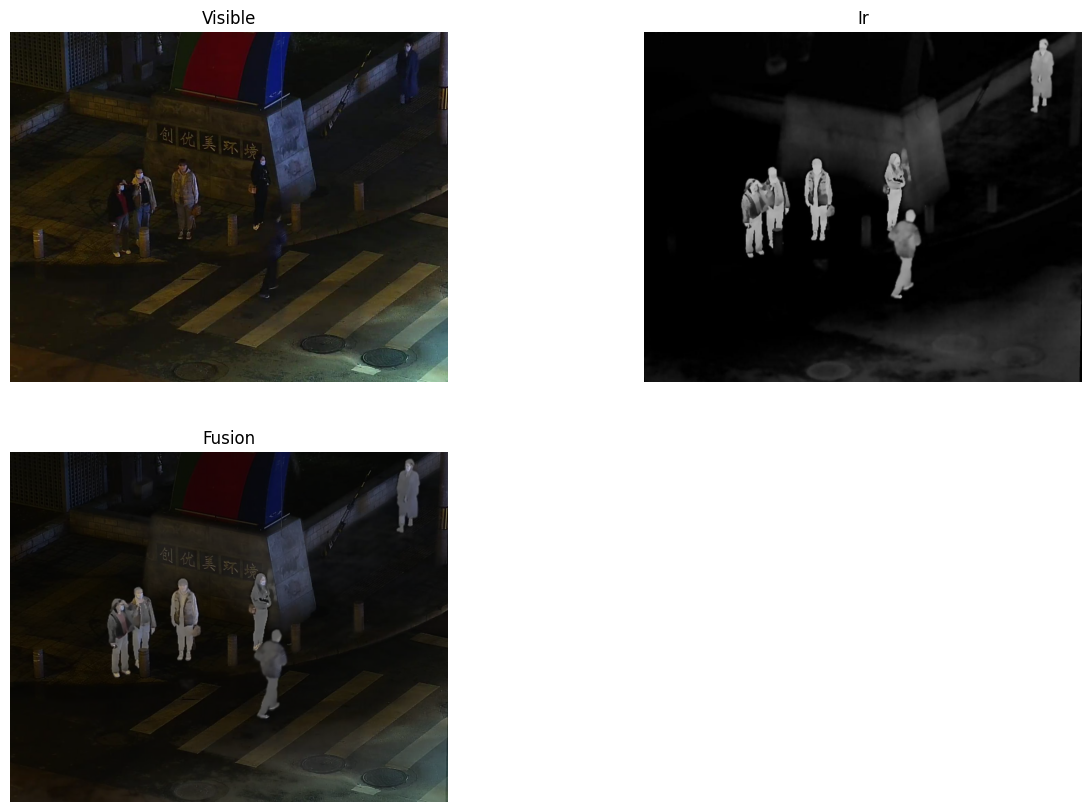

In [ ]:
low_fused = (graylow + irlow) / 2
high_fused = saliency_max

fusion = low_fused + high_fused

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(gray, 'gray')
plt.axis('off')
plt.title('Visible')

plt.subplot(2, 2, 2)
plt.imshow(ir, 'gray')
plt.axis('off')
plt.title('Ir')

plt.subplot(2, 2, 3)
plt.imshow(fusion, 'gray')
plt.axis('off')
plt.title('Fusion')